 <a id="1"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">IMPORTING LIBRARIES</p>

In [1]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
import wordcloud
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

<a id="2"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>

In [2]:
#Loading data
data = pd.read_csv("spam.csv",encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [3]:
# Dropping the redundent looking columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.describe()

,Target,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Text(0, 0.5, 'Number of Data points')

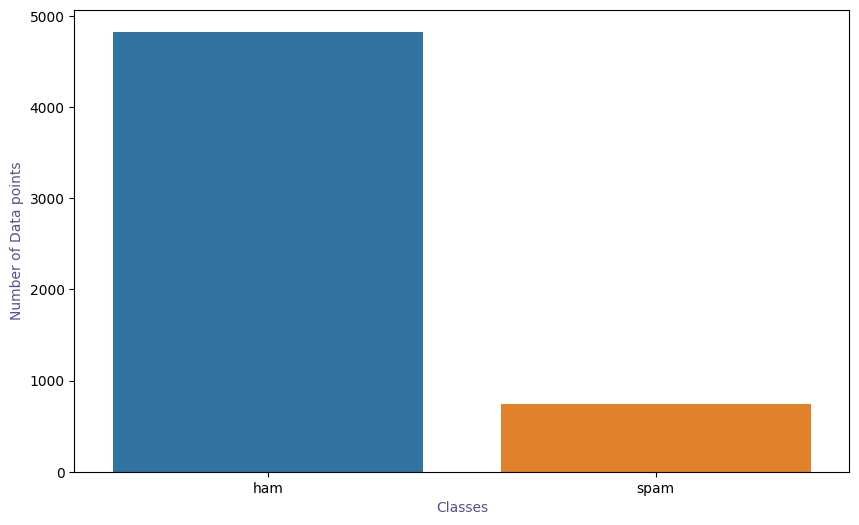

In [5]:
#Palette
cols= ["#E1F16B", "#E598D8"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(10,6))
fg = sns.countplot(x= data["Target"])#, palette= cols)
#fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

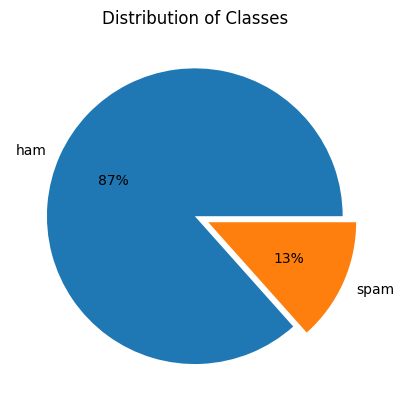

In [6]:
plt.pie(data['Target'].value_counts(),labels = ["ham", "spam"], autopct='%.0f%%', explode=[0,0.1])
plt.title('Distribution of Classes')
plt.show()

In [7]:
ham_data = data[data["Target"]=="ham"].copy()
spam_data = data[data["Target"]=="spam"].copy()

In [8]:
def view_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['Text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)

    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)

    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

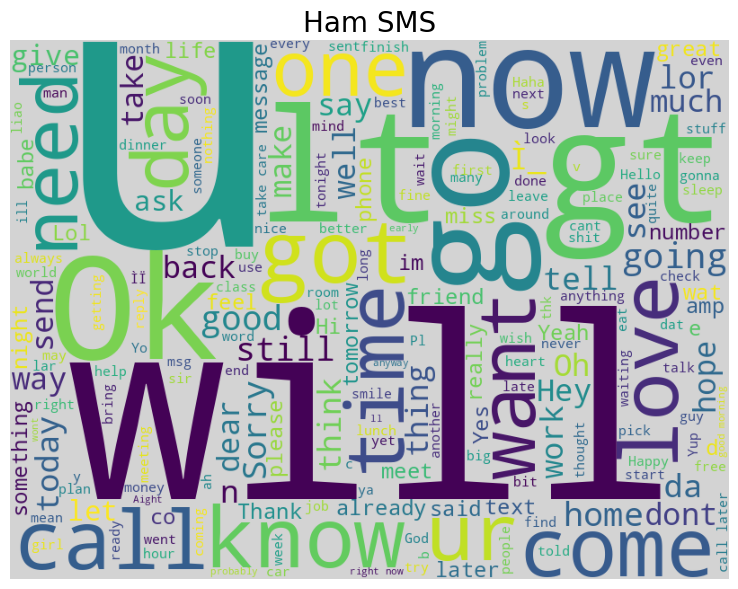

In [9]:
view_wordcloud(ham_data, "Ham SMS")

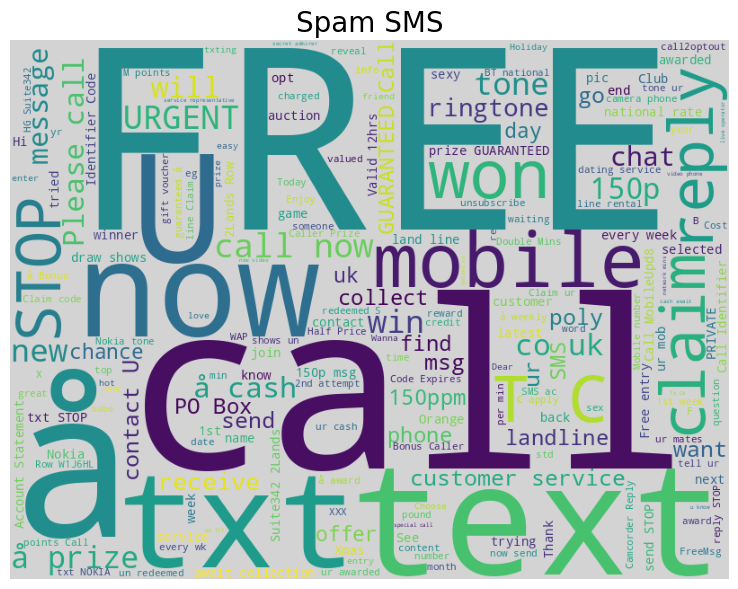

In [10]:
view_wordcloud(spam_data, "Spam SMS")

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Note:** From the above countplot the data imbalance is quite evident.

<a id="3.1"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">FEATURE ENGINEERING</p>

For the purpose of data exploration, I am creating new features

* No_of_Characters: Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_sentence: Number of sentences in the text message  

In [12]:
data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1)

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Length: 5572, dtype: object

In [13]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["Num_of_Characters"] = data["Text"].apply(len)
data["Num_of_Words"]=data.apply(lambda row: nltk.tokenize.word_tokenize(row["Text"]), axis=1).apply(len)
data["Num_of_sentence"]=data.apply(lambda row: nltk.tokenize.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Num_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
Num_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
Num_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

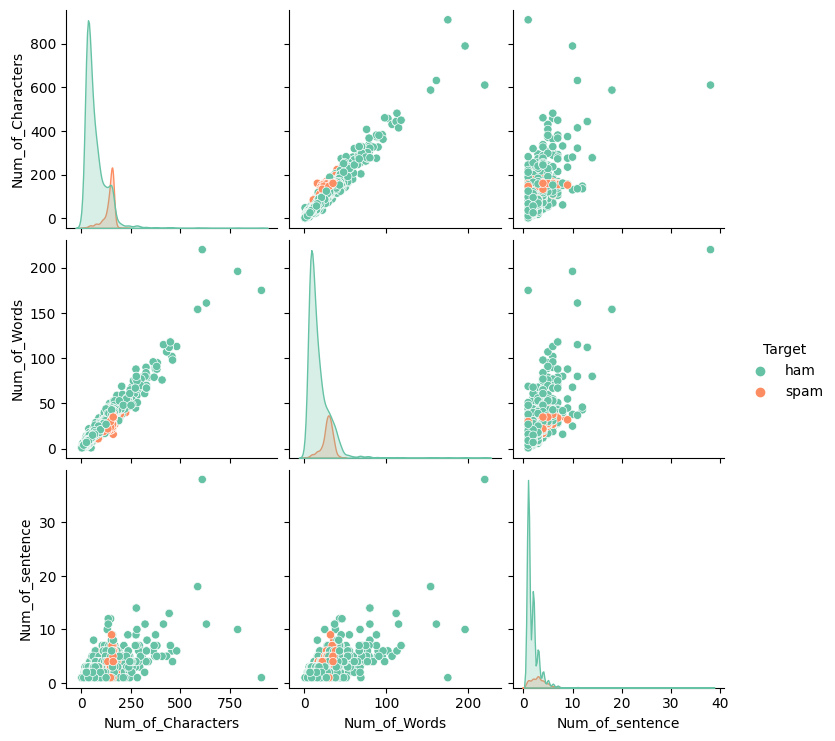

In [14]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette="Set2")
plt.show(fg)

**Note:** From the pair plot, we can see a few outliers all in the class ham. Next, we would drop them.

##OUTLIER DETECTION

In [15]:
#Dropping the outliers.
data = data[(data["Num_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

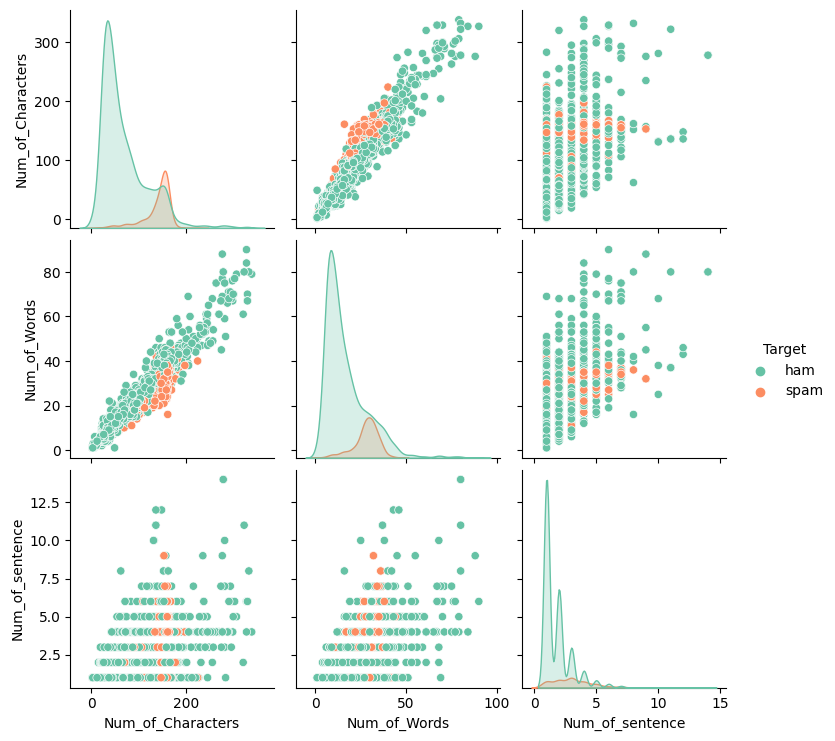

In [16]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette="Set2")
plt.show(fg)

## DATA PREPREPROCESSING

###CLEANING TEXT

In [17]:
# Lets have a look at a sample of texts before cleaning
print("The First 5 Texts:",*data["Text"][:5], sep = "\n")

The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [18]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

#Lets have a look at a sample of texts after cleaning
print("The First 5 Texts after Cleaning:",*data["Clean_Text"][:5], sep = "\n")

The First 5 Texts after Cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


###TOKENIZATION

In [19]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("The First 5 Texts after Tokenizing:",*data["Tokenize_Text"][:5], sep = "\n")

The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


###REMOVING STOPWORDS

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("The First 5 Texts after removing the stopwords:",*data["Nostopword_Text"][:5], sep = "\n")

The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


###LEMMATIZATION

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("The First 5 Texts after lemitization:",*data["Lemmatized_Text"][:5], sep = "\n")

The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


### VECTORIZE using TF-IDF

In [24]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("The First 5 lines in corpus:",*corpus[:5], sep = "\n")

The First 5 lines in corpus:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [25]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's check the feature
X.dtype

dtype('float64')

In [26]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

In [27]:
data.head()

,Target,Text,Num_of_Characters,Num_of_Words,Num_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


##MODEL BUILDING

### Normal Dataset (Unnormalized)

In [28]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               SVC(random_state=42),
               LogisticRegression(random_state=42)]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC",4: "LogisticRegression"}

In [30]:
# Crossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.963173 
RandomForest: 0.973733 
KNeighbours: 0.908063 
SVC: 0.972961 
LogisticRegression: 0.952098 


### Normal Dataset (Normalized)

In [31]:
# With normalization
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X_train)
X2_test = scaler.transform(X_test)

In [32]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               SVC(random_state=42),
               LogisticRegression(random_state=42)]
for cls in classifiers:
    cls.fit(X2_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC",4: "LogisticRegression"}

In [33]:
# Crossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X2_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.976047 
RandomForest: 0.973733 
KNeighbours: 0.902396 
SVC: 0.969099 
LogisticRegression: 0.972188 


### Oversampled Dataset (Unnormalized)

In [34]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X3_train, y3_train = smote.fit_resample(X_train, y_train)

In [35]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               SVC(random_state=42),
               LogisticRegression(random_state=42)]
for cls in classifiers:
    cls.fit(X3_train, y3_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC",4: "LogisticRegression"}

In [36]:
# Crossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X3_train,y3_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.980179 
RandomForest: 0.992697 
KNeighbours: 0.994039 
SVC: 0.997615 
LogisticRegression: 0.986736 


### Oversampled Dataset (Normalized)

In [37]:
# With normalization
scaler = MinMaxScaler()
X4_train = scaler.fit_transform(X3_train)
X4_test = scaler.transform(X_test)

In [38]:
#Testing on the following classifiers
classifiers2 = [MultinomialNB(),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               SVC(random_state=42),
               LogisticRegression(random_state=42)]
for cls in classifiers2:
    cls.fit(X4_train, y3_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC",4: "LogisticRegression"}

In [39]:
# Crossvalidation
for i, model in enumerate(classifiers2):
    cv_score = cross_val_score(model, X4_train,y3_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.986587 
RandomForest: 0.992697 
KNeighbours: 0.995678 
SVC: 0.998808 
LogisticRegression: 0.995976 


## EVALUATING MODELS

**Testing the models on Testset**
* Classification Report
* Confusion Matrix

### Unnormalized

In [40]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train,y_train)
    test_accuracy = i.score(X_test,y_test)

    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [41]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC","LogisticRegression"])

In [42]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.818182,0.945205,0.877119,0.965165,0.978625
RandomForest,1.000000,0.858447,0.923833,0.981381,1.000000
KNeighbours,0.947368,0.657534,0.776280,0.950150,0.996910
SVC,0.994444,0.817352,0.897243,0.975375,0.999742
LogisticRegression,0.942029,0.890411,0.915493,0.978378,0.990986


### Normalized

In [43]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers2:
    pred_train = i.predict(X2_train)
    pred_test = i.predict(X2_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X2_train,y_train)
    test_accuracy = i.score(X2_test,y_test)

    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [44]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC","LogisticRegression"])

In [45]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.810277,0.936073,0.868644,0.962763,0.985063
RandomForest,1.000000,0.858447,0.923833,0.981381,1.000000
KNeighbours,0.987013,0.694064,0.815013,0.958559,0.998455
SVC,0.994652,0.849315,0.916256,0.979580,0.999227
LogisticRegression,0.970000,0.885845,0.926014,0.981381,0.997425


### CONFUSION MATRIX (UNNORMALIZED)

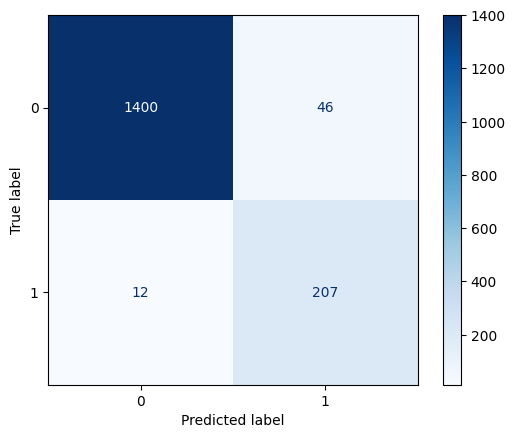

In [46]:
cls = MultinomialNB().fit(X3_train, y3_train)
pred_test = cls.predict(X_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

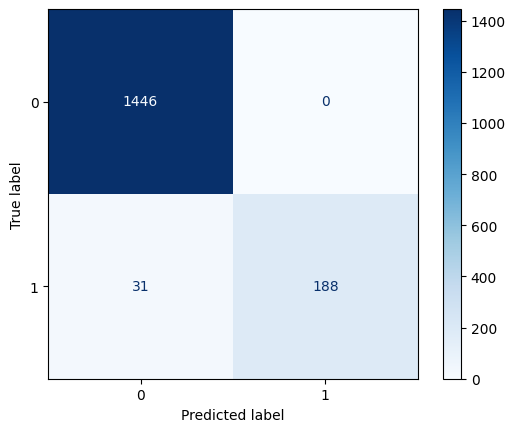

In [47]:
cls = RandomForestClassifier().fit(X3_train, y3_train)
pred_test = cls.predict(X_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

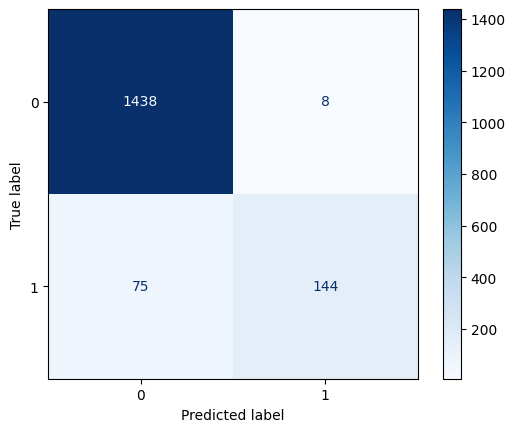

In [48]:
cls = KNeighborsClassifier().fit(X3_train, y3_train)
pred_test = cls.predict(X_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

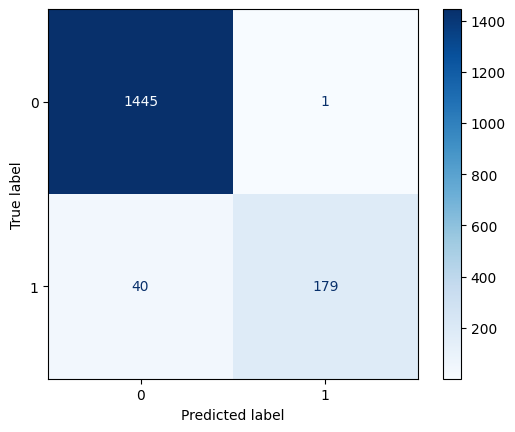

In [49]:
cls = SVC().fit(X3_train, y3_train)
pred_test = cls.predict(X_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

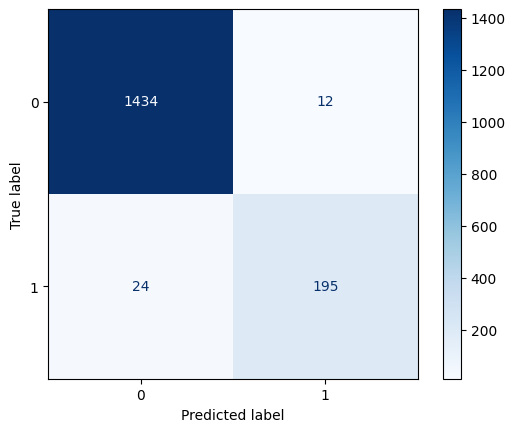

In [50]:
cls = LogisticRegression().fit(X3_train, y3_train)
pred_test = cls.predict(X_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

### CONFUSION MATRIX (NORMALIZED)

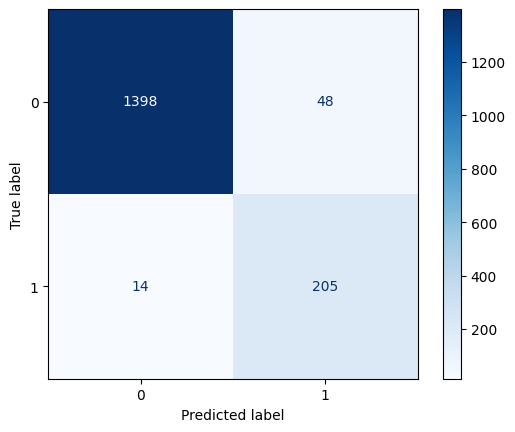

In [51]:
cls = MultinomialNB().fit(X4_train, y3_train)
pred_test = cls.predict(X4_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

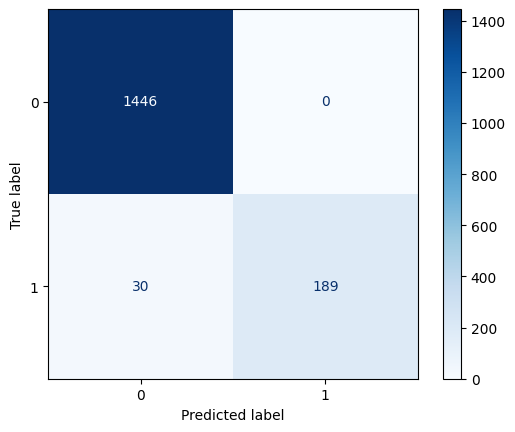

In [52]:
cls = RandomForestClassifier().fit(X4_train, y3_train)
pred_test = cls.predict(X4_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

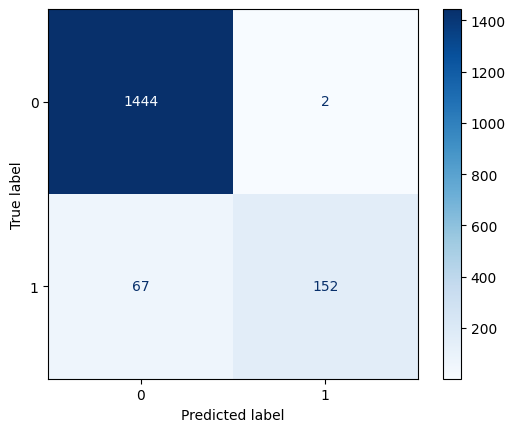

In [53]:
cls = KNeighborsClassifier().fit(X4_train, y3_train)
pred_test = cls.predict(X4_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

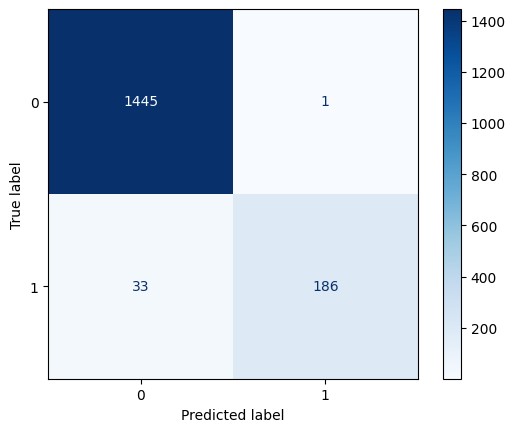

In [54]:
cls = SVC().fit(X4_train, y3_train)
pred_test = cls.predict(X4_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()

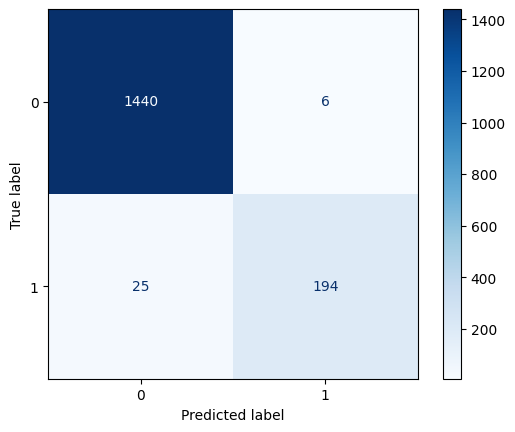

In [55]:
cls = LogisticRegression().fit(X4_train, y3_train)
pred_test = cls.predict(X4_test)

cm = confusion_matrix(y_test, pred_test, labels=cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cls.classes_)
disp.plot(cmap='Blues')
plt.show()